In [153]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from dataset import BrightfieldMicroscopyDataset

from scipy.fft import fft2, ifft2, fftshift, ifftshift

In [154]:
train_set = BrightfieldMicroscopyDataset()

In [155]:
image, label = train_set[0]

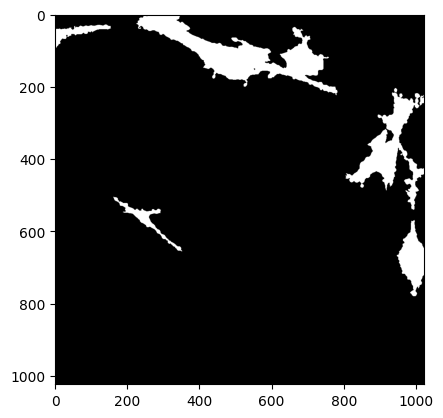

In [156]:
plt.imshow(label, cmap='gray')

In [157]:
def remove_repeating_pattern(image, threshold=0.1, iterations=1):
    """
    Removes repeating patterns from an image using FFT.
    
    Parameters:
    - image: 2D numpy array, the input image.
    - threshold: float, threshold for identifying peaks in the frequency domain.
    - iterations: int, number of iterations to refine the pattern removal.

    Returns:
    - cleaned_image: 2D numpy array, the image with the pattern removed.
    """
    # original = image.copy()
    for _ in range(iterations):
        # Step 1: FFT to frequency domain
        f = fft2(image)
        fshift = fftshift(f)
        magnitude = np.abs(fshift)

        # Step 2: Identify pattern frequencies
        mask = magnitude > (threshold * np.max(magnitude))
        pattern_fshift = fshift * mask

        # Step 3: Reconstruct pattern using inverse FFT
        pattern = np.real(ifft2(ifftshift(pattern_fshift)))

        # Step 4: Subtract pattern from original image
        image = image - pattern

    return image

In [ ]:
def visualize_data(image, label, channels_to_plot=None):
    """
    Visualizes the original image, FFT spectrum, and filtered image for each channel.
    
    Parameters:
    - image: numpy array of shape (channels, height, width), the input image stack.
    """
    channels = image.shape[0]
    plt.figure(figsize=(15, channels * 5))  # Adjust figure size for better visualization

    if channels_to_plot is None:
        channels_to_plot = channels

    for i in range(channels_to_plot):
        # Plot the channel image
        plt.subplot(channels, 7, 7 * i + 1)  # Column 1: Original image
        plt.imshow(image[i], cmap='gray')
        plt.axis('off')
        plt.title(f"Channel {i + 1}")
        
        # Compute the FFT spectrum
        f = np.fft.fft2(image[i])
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = np.log(np.abs(fshift) + 1)  # Log scale for better visualization

        # Plot the FFT spectrum
        plt.subplot(channels, 7, 7 * i + 2)  # Column 2: FFT spectrum
        plt.imshow(magnitude_spectrum, cmap='gray')
        plt.axis('off')
        plt.title(f"FFT Spectrum {i + 1}")

        # Remove repeating pattern
        cleaned_image = remove_repeating_pattern(image[i], threshold=0.01, iterations=2)

        # Plot the cleaned image
        plt.subplot(channels, 7, 7 * i + 3)  # Column 3: Filtered image
        plt.imshow(cleaned_image, cmap='gray')
        plt.axis('off')
        plt.title(f"Filtered Image {i + 1}")

        tensor_min = cleaned_image.min()
        tensor_max = cleaned_image.max()
        normalized_tensor = (cleaned_image - tensor_min) / (tensor_max - tensor_min) * 255

        # Step 2: Convert to NumPy array and change dtype to np.uint8
        image_uint8 = normalized_tensor.numpy().astype(np.uint8)

        edged = cv2.Canny(image_uint8, 70, 80)

        plt.subplot(channels, 7, 7 * i + 4)  # Column 3: Filtered image
        plt.imshow(edged, cmap='gray')
        plt.axis('off')
        plt.title(f"Canny edges {i + 1}")


        # opened = cv2.morphologyEx(edged, cv2.MORPH_OPEN, kernel)
        diation_kernel = np.ones((4,4),np.uint8)
        dilated = cv2.dilate(edged,diation_kernel,iterations = 1)

        plt.subplot(channels, 7, 7 * i + 5)  # Column 3: Filtered image
        plt.imshow(dilated, cmap='gray')
        plt.axis('off')
        plt.title(f"Filtered canny {i + 1}")

        ret,thresh1 = cv2.threshold(dilated,200,255,cv2.THRESH_BINARY)

        plt.subplot(channels, 7, 7 * i + 6)  # Column 3: Filtered image
        plt.imshow(thresh1, cmap='gray')
        plt.axis('off')
        plt.title(f"Label mask {i + 1}")

        plt.subplot(channels, 7, 7 * i + 7)  # Column 3: Filtered image
        plt.imshow(label, cmap='gray')
        plt.axis('off')
        plt.title(f"Label mask {i + 1}")

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_17172/656084033.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image = image - pattern


200.0


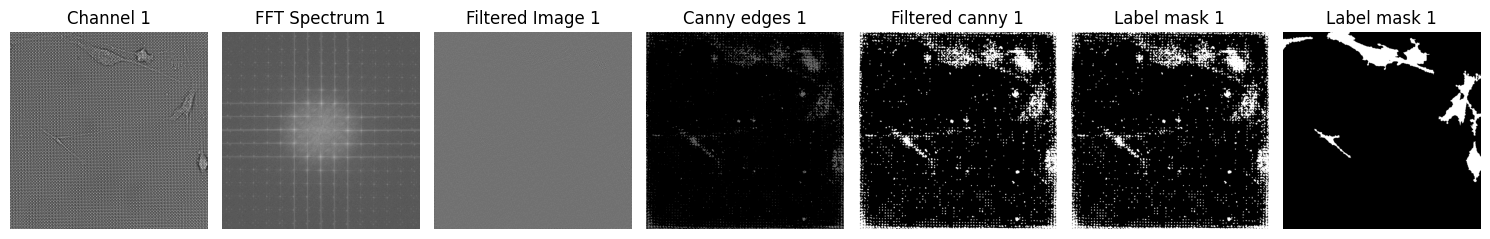

In [192]:
visualize_data(image, label, channels_to_plot=1)

/tmp/ipykernel_17172/656084033.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  image = image - pattern


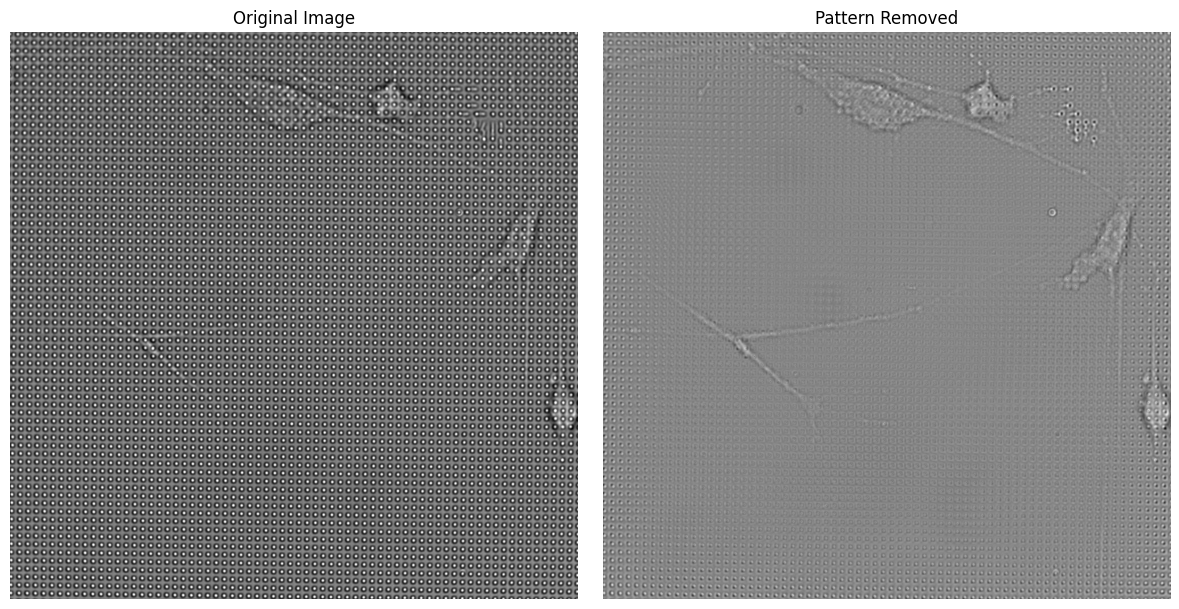

In [160]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image[0], cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Remove pattern
cleaned_image = remove_repeating_pattern(image[0], threshold=0.1, iterations=2)

plt.subplot(1, 2, 2)
plt.imshow(cleaned_image, cmap='gray')
plt.title("Pattern Removed")
plt.axis('off')

plt.tight_layout()
plt.show()